In [1]:
import pandas as pd
from scipy.stats import binom_test, fisher_exact
from genepy.utils import helper as h 
from genepy.utils import plot
from genepy.imaging import fish
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import fisher_exact, chi2_contingency, ttest_ind
from scipy.spatial import distance_matrix
import numpy as np

%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython

## Processing the data

In [ ]:
project='FishSuperResColoc'
version='v2'

In [5]:
rename = {
"Text Between Delimiters":"subset",
"Folder Short":"folder_short",
"Folder Path":"folder",
"Source.Name":"name",
"ImageDocumentName::Image Name":"image",
"ParentID::ID of the parent!!I":"parent_id",
"ID::ID!!I":"id",
"RegionsCount::Count!!I": "count",
"ImageSceneName::Image Scene Name ":"scene",
"Area1::Area Unscaled!!R":"area_u",
"Area::Area!!R": "area",
"CenterX1::Center X Unscaled!!R":"x",
"CenterY1::Center Y Unscaled!!R":"y",
"ImageScaleX::Image Scale X!!R":"scale_x",
"ImageScaleY::Image Scale Y!!R":"scale_y",
"ImageIndexZ::Image Index Z!!I":"z",
'Classes 5 RegionsCount ::Classes 5 Count!!I':"count_red",
'Classes 9 RegionsCount ::Classes 9 Count!!I':"count_green",
"ClassColorName::Region Class Color Name": "class",
"IntensityMaximum_TV1-T1-SR::Intensity Maximum of channel 'TV1-T1-SR'!!R":"max_red",
"IntensityMaximum_TV2-T1-SR::Intensity Maximum of channel 'TV2-T1-SR'!!R":"max_tv2_t1",
"IntensityMaximum_TV2-T2-SR::Intensity Maximum of channel 'TV2-T2-SR'!!R":"max_green",
"IntensityMaximum_TV2-T3-SR::Intensity Maximum of channel 'TV2-T3-SR'!!R":"max_dapi",
"IntensityMean_TV1-T1-SR::Intensity Mean Value of channel 'TV1-T1-SR'!!R":"mean_red",
"IntensityMean_TV2-T1-SR::Intensity Mean Value of channel 'TV2-T1-SR'!!R":"mean_tv2_t1",
"IntensityMean_TV2-T2-SR::Intensity Mean Value of channel 'TV2-T2-SR'!!R":"mean_green",
"IntensityMean_TV2-T3-SR::Intensity Mean Value of channel 'TV2-T3-SR'!!R":"mean_dapi",
"IntensityMinimum_TV1-T1-SR::Intensity Minimum of channel 'TV1-T1-SR'!!R":"min_red",
"IntensityMinimum_TV2-T1-SR::Intensity Minimum of channel 'TV2-T1-SR'!!R":"min_tv2_t1",
"IntensityMinimum_TV2-T2-SR::Intensity Minimum of channel 'TV2-T2-SR'!!R":"min_green",
"IntensityMinimum_TV2-T3-SR::Intensity Minimum of channel 'TV2-T3-SR'!!R":"min_dapi",
"IntensitySum0_TV1-T1-SR::Intensity Pixel Count of channel 'TV1-T1-SR'!!R":"pixsum_red",
"IntensitySum0_TV2-T1-SR::Intensity Pixel Count of channel 'TV2-T1-SR'!!R":"pixsum_tv2_t1",
"IntensitySum0_TV2-T2-SR::Intensity Pixel Count of channel 'TV2-T2-SR'!!R":"pixsum_green",
"IntensitySum0_TV2-T3-SR::Intensity Pixel Count of channel 'TV2-T3-SR'!!R":"pixsum_dapi",
"IntensityRange_TV1-T1-SR::Intensity Range of channel 'TV1-T1-SR'!!R":"range_red",
"IntensityRange_TV2-T1-SR::Intensity Range of channel 'TV2-T1-SR'!!R":"range_tv2_t1",
"IntensityRange_TV2-T2-SR::Intensity Range of channel 'TV2-T2-SR'!!R":"range_green",
"IntensityRange_TV2-T3-SR::Intensity Range of channel 'TV2-T3-SR'!!R":"range_dapi",
"IntensityStd_TV1-T1-SR::Intensity Standard Deviation of channel 'TV1-T1-SR'!!R":"std_red",
"IntensityStd_TV2-T1-SR::Intensity Standard Deviation of channel 'TV2-T1-SR'!!R":"std_tv2_t1",
"IntensityStd_TV2-T2-SR::Intensity Standard Deviation of channel 'TV2-T2-SR'!!R":"std_green",
"IntensityStd_TV2-T3-SR::Intensity Standard Deviation of channel 'TV2-T3-SR'!!R":"std_dapi",
"IntensitySum1_TV1-T1-SR::Intensity Sum of channel 'TV1-T1-SR'!!R":"sum_red",
"IntensitySum1_TV2-T1-SR::Intensity Sum of channel 'TV2-T1-SR'!!R":"sum_tv2_t1",
"IntensitySum1_TV2-T2-SR::Intensity Sum of channel 'TV2-T2-SR'!!R":"sum_green",
"IntensitySum1_TV2-T3-SR::Intensity Sum of channel 'TV2-T3-SR'!!R":"sum_dapi",
"IntensitySum2_TV1-T1-SR::Intensity Sum Squares of channel 'TV1-T1-SR'!!R":"sum2_red",
"IntensitySum2_TV2-T1-SR::Intensity Sum Squares of channel 'TV2-T1-SR'!!R":"sum2_tv2_t1",
"IntensitySum2_TV2-T2-SR::Intensity Sum Squares of channel 'TV2-T2-SR'!!R":"sum2_green",
"IntensitySum2_TV2-T3-SR::Intensity Sum Squares of channel 'TV2-T3-SR'!!R":"sum2_dapi",
"Unnamed: 27":"unknown"
}

In [80]:
data = pd.read_csv('../data/'+project+'/data_query_files/querry.csv').rename(columns=rename)
data

,subset,folder_short,folder,name,image,parent_id,id,scene,area,x,...,sum_1,sum_2,range_1,range_2,std_1,std_2,sum1_1,sum1_2,sum2_1,sum2_2
0,Subset10,AAVS1_CRISPR_MED1\AAVS1_CRISPR_MED1 Image7\,C:\Users\M232498\Desktop\Ju\GDrive\IF FISH fin...,Image 7_Subset10_Out_Maximum intensity project...,NaN,NaN,NaN,NaN,pixel²,pixel,...,pixel²,pixel²,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown²,Unknown²
1,Subset10,AAVS1_CRISPR_MED1\AAVS1_CRISPR_MED1 Image7\,C:\Users\M232498\Desktop\Ju\GDrive\IF FISH fin...,Image 7_Subset10_Out_Maximum intensity project...,Image 7_Subset10_Out_Maximum intensity project...,14.0,15.0,NaN,7,368.64285714286,...,7,7,1661,4080,547.72403548468,1510.241245314,49094,164490,346117272,3878964986
2,Subset10,AAVS1_CRISPR_MED1\AAVS1_CRISPR_MED1 Image7\,C:\Users\M232498\Desktop\Ju\GDrive\IF FISH fin...,Image 7_Subset10_Out_Maximum intensity project...,Image 7_Subset10_Out_Maximum intensity project...,14.0,16.0,NaN,28,396.21428571429,...,28,28,8089,13818,2760.2006509669,3701.1435641623,123989,523204,754750539,10146373720
3,Subset10,AAVS1_CRISPR_MED1\AAVS1_CRISPR_MED1 Image7\,C:\Users\M232498\Desktop\Ju\GDrive\IF FISH fin...,Image 7_Subset10_Out_Maximum intensity project...,Image 7_Subset10_Out_Maximum intensity project...,14.0,17.0,NaN,13,426.88461538462,...,13,13,4583,6576,1313.3590522016,2101.7813019022,108303,285907,922971237,6340918481
4,Subset10,AAVS1_CRISPR_MED1\AAVS1_CRISPR_MED1 Image7\,C:\Users\M232498\Desktop\Ju\GDrive\IF FISH fin...,Image 7_Subset10_Out_Maximum intensity project...,Image 7_Subset10_Out_Maximum intensity project...,14.0,18.0,NaN,29,340.74137931035,...,29,29,3515,12083,1077.0374837392,3107.8328355138,196046,460225,1357791794,7574132899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117757,Subset9,IF FISH final\Runx2_excel\,C:\Users\M232498\Desktop\Ju\GDrive\IF FISH fin...,Runx2_488_MYC_FISH_SIM-Orthogonal Projection-0...,Runx2_488_MYC_FISH_SIM-Orthogonal Projection-0...,1.0,23.0,NaN,55230,1146.4196089082,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117758,Subset9,IF FISH final\Runx2_excel\,C:\Users\M232498\Desktop\Ju\GDrive\IF FISH fin...,Runx2_488_MYC_FISH_SIM-Orthogonal Projection-0...,Runx2_488_MYC_FISH_SIM-Orthogonal Projection-0...,1.0,24.0,NaN,60384,1546.5754835718,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117759,Subset9,IF FISH final\Runx2_excel\,C:\Users\M232498\Desktop\Ju\GDrive\IF FISH fin...,Runx2_488_MYC_FISH_SIM-Orthogonal Projection-0...,Runx2_488_MYC_FISH_SIM-Orthogonal Projection-0...,1.0,25.0,NaN,48042,2480.9880521211,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117760,Subset9,IF FISH final\Runx2_excel\,C:\Users\M232498\Desktop\Ju\GDrive\IF FISH fin...,Runx2_488_MYC_FISH_SIM-Orthogonal Projection-0...,Runx2_488_MYC_FISH_SIM-Orthogonal Projection-0...,1.0,26.0,NaN,70306,1932.6927004808,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
data.columns

Index(['subset', 'folder_short', 'folder', 'name', 'image', 'parent_id', 'id',
       'scene', 'area', 'x', 'y', 'max_1', 'max_2', 'mean_1', 'mean_2',
       'min_1', 'min_2', 'sum_1', 'sum_2', 'range_1', 'range_2', 'std_1',
       'std_2', 'sum1_1', 'sum1_2', 'sum2_1', 'sum2_2'],
      dtype='object')

In [5]:
cat ../data/$project/data_query_files/querry.csv | less

<U+FEFF>Text Between Delimiters,Folder Short,Folder Path,Source.Name,ImageDocumentName::Image Name,ParentID::ID of the parent!!I,ID::ID!!I,ImageSceneName::Image Scene Name ,Area1::Area Unscaled!!R,CenterX1::Center X Unscaled!!R,CenterY1::Center Y Unscaled!!R,IntensityMaximum_TV1-T1-SR::Intensity Maximum of channel 'TV1-T1-SR'!!R,IntensityMaximum_TV2-T1-SR::Intensity Maximum of channel 'TV2-T1-SR'!!R,IntensityMean_TV1-T1-SR::Intensity Mean Value of channel 'TV1-T1-SR'!!R,IntensityMean_TV2-T1-SR::Intensity Mean Value of channel 'TV2-T1-SR'!!R,IntensityMinimum_TV1-T1-SR::Intensity Minimum of channel 'TV1-T1-SR'!!R,IntensityMinimum_TV2-T1-SR::Intensity Minimum of channel 'TV2-T1-SR'!!R,IntensitySum0_TV1-T1-SR::Intensity Pixel Count of channel 'TV1-T1-SR'!!R,IntensitySum0_TV2-T1-SR::Intensity Pixel Count of channel 'TV2-T1-SR'!!R,IntensityRange_TV1-T1-SR::Intensity Range of channel 'TV1-T1-SR'!!R,IntensityRange_TV2-T1-SR::Intensity Range of channel 'TV2-T1-SR'!!R,IntensityStd_TV1-T1-SR::Int

In [ ]:
data.iloc[0].tolist()

In [ ]:
set(data.folder_short)

In [ ]:
cond = {'AAVS1_CRISPR_MED1\\AAVS1_CRISPR_MED1 Image7\\':'AAVS1',
 'IF FISH final\\AAVS1_CRISPR_MEF2D\\':'AAVS1',
 'IF FISH final\\IRF2BP2_excel\\':'',
 'IF FISH final\\MEF2C_excel\\':'',
 'IF FISH final\\MEF2D_CRISPR_MED1\\':'MEF2D',
 'IF FISH final\\MEF2D_CRISPR_MEF2D\\':'MEF2D',
 'IF FISH final\\Runx2_excel\\':''}

In [ ]:
prot = {'AAVS1_CRISPR_MED1\\AAVS1_CRISPR_MED1 Image7\\':'MED1',
 'IF FISH final\\AAVS1_CRISPR_MEF2D\\':'MEF2D',
 'IF FISH final\\IRF2BP2_excel\\':'IRF2BP2',
 'IF FISH final\\MEF2C_excel\\':'MEF2C',
 'IF FISH final\\MEF2D_CRISPR_MED1\\':'MED1',
 'IF FISH final\\MEF2D_CRISPR_MEF2D\\':'MEF2D',
 'IF FISH final\\Runx2_excel\\':'RUNX2'}

In [ ]:
data = data[~data.name.str.contains('Classes')]

In [ ]:
data['condition'] = [cond[i] for i in data.folder_short]

In [ ]:
data['protein'] = [prot[i] for i in data.folder_short]

In [ ]:
data['type'] = [i.split('.')[0].split('_')[-1] for i in data.name]

In [ ]:
data['name'] = [cond[i]+'_'+prot[i] for i in data.folder_short]

In [ ]:
set(data.type)

In [ ]:
data = data[~data.id.isna()]

In [ ]:
set(data.subset)

In [ ]:
data = data.drop(columns=['scene','image','folder','folder_short'])

In [ ]:
data['subset'] = [i.split('Subset')[-1] for i in data.subset]

In [ ]:
for val in ['area','x','y','max_1','max_2','mean_1','mean_2','min_1','min_2','range_1','range_2','std_1','std_2','sum_1','sum_2','sum1_1','sum1_2','sum2_1','sum2_2']:
    data[val]= data[val].astype(float)

In [ ]:
for val in ['subset','parent_id','id']:
    data[val] = data[val].astype('int')

In [ ]:
len(data.id)

# results

## why we are not doing a monte carlo but just a hypthesis testing on a binomial

monte carlo would be useful in our case if we did not know the expected distribution.
given a way to generate our distribution (which specific parameters can be learnt from the data) we might be able to express what would be the null hypothesis by estimating this unknown distribution. it is useful for when we don't know the exact distribution or when it is too complex to analytically solve.  

However in our case we can approximate the distribution well enough by a binomial. It is true that given that the dna will not have the same density everywhere on the nucleus, that the dots will have themselves variable intensity and size, which might express or not a multiplicity of points, the distribution is not a binomial. 

But you said yourself that for all purposes we could simplify these hypothesis. 

I also don't think that we have enough data points to correctly estimate the monte carlo parameters. 

A binomial is thus enough for this analysis

### having specificities in the data needing to be modelled:

I found that the data has specific bias that still need to be taken in account while not needing to change the statistics:

the avg size of a MYC dot is 350 whereas the one of a MYC green is 45

In [ ]:
def desc(data):
    return data.sum()/data.mean(),len(data)
# for each group
res = {}
for val in set(data.name):
    print('\n',val)
    group = data[data.name==val]
    space = group[group.type=='Nucleus'].area.sum()
    totsize = group[group.type==' Green Dots'].area.sum()
                 
    coloc,s_coloc = desc(group[group.type=='MYC  Green'].area)
    outside,s_outside = desc(group[group.type=='MYC'].area)
    print('data: \n  - total nucleuses size: '+str(int(space))+'\n  - total Green dot size: '+str(int(totsize))+'\n  - counts for coloc: '+str(int(s_coloc))+'\n  - counts for not coloc: '+str(int(s_outside))) 
    p_in = totsize/space
    isin = coloc/(outside+coloc)
    res[val] = [s_coloc,s_outside]
    print('proba: (null, obs)',p_in,isin)
    print('nb of datapoints: ',s_coloc+s_outside)
    print('p_value: ',binom_test([s_coloc,s_outside],p=p_in))

from this analysis it seems clear that the colocalization happens less than 50% of the time in any condition but that we have colocalization with MYC for all analyzed proteins compared to random chance, given the data extracted by the algorithm and the assumption we made.

In [ ]:
fisher_exact([res['AAVS1_MED1'], res['MEF2D_MED1']])

In [ ]:
fisher_exact([res['AAVS1_MEF2D'], res['MEF2D_MEF2D']])

we thus have much 1.7 times more colocalization of MEF2D when MEF2D is degraded vs when it is not and 2 times less colocalization of MED1 but p_val of .1

# running new version

## Loading

In [2]:
project='FishSuperResColoc'
version='IRF2BP2_v3'

In [81]:
csvs = ! ls ../data/micro_IRF2BP2/*/*.csv #micro_Yaser3, #micro_MEF2D_MEF2C
res = pd.DataFrame()
for val in csvs:
    v = pd.read_csv(val,).drop(index=0)
    v['filename'] = '-'.join(val.split('/')[-2].split('-')[2:])
    res = res.append(v)
res = res.rename(columns=rename)
res.parent_id = res.parent_id.astype(int)
res.id = res.id.astype(int)
res.area = res.area.astype(float)
res = res.reset_index(drop=True)

## labelling

In [82]:
unstring =  ['area', 'x', 'y', "z", "scale_x", "scale_y", "count_red", "count_green", "max_red", "max_green", "max_dapi", "mean_red", "mean_green", "mean_dapi", "min_red", "min_green", "min_dapi", "pixsum_red", "pixsum_green", "pixsum_dapi", "range_red", "range_green", "range_dapi", "std_red", "std_green", "std_dapi", "sum_red", "sum_green", "sum_dapi", "sum2_red", "sum2_green", "sum2_dapi"]
zsize = 85 
toint=['parent_id',"id","area","z","count_red","count_green"]
torn = {'Orange':"dapi", 'Fuchsia': "green", "Yellow": 'red'}

In [85]:
imageinfo

0          4--1-1
1          4--1-1
2          4--1-1
3          4--1-1
4          4--1-1
           ...   
149637    25--4-4
149638    25--4-4
149639    25--4-4
149640    25--4-4
149641    25--4-4
Name: image, Length: 149642, dtype: object

In [83]:
res[unstring] = pd.concat([res[i].astype(str).str.replace('  ','0').replace(' ','0').replace('', '0').replace('None',"0").astype(float) for i in unstring], axis=1)

res['x']= res['x']*res["scale_x"]
res['y']= res['y']*res["scale_y"]
res["z"]= res['z']*zsize
res = res.drop(columns=['area_u',"scale_x",'scale_y'])
print(set(res['filename']))

imageinfo = res['image'].str.replace('_Subset.czi', '').str.replace('Subset.czi', '').str.replace('.czi', '').str.replace('Image ', '').str.replace('_SIM_Channel Alignment_P', "--").str.replace('_Out_Channel Alignment_P',"--").str.replace('_P', '--')
res['group'] = res['filename'] + "--" + imageinfo
#res['exp'] = ['-'.join(i.split('-')[:2]+i.split('-')[3:]) for i in res.filename]
res["exp"] = ['-'.join(i.split('-')[:2]+i.split('-')[3:]) for i in res.filename]
res['treat'] = [i.split('-')[-2] for i in res.filename]
res['image'] = [i.split('--')[0] for i in imageinfo]
res['part'] = [i.split('--')[-1] for i in imageinfo]
print('number of exp')
print(set(res.exp))

res['class'] = res['class'].replace(torn)
res = res.drop(index=res[res['class'].isna()].index)
res[toint] = res[toint].astype(int)

{'IRF2BP2-MYC-DMSO-G1', 'MED1_MYC-IRF2BP2-VHL-G1', 'IRF2BP2-MYC-VHL-G1', 'MED1_MYC-IRF2BP2-DMSO-G1'}


<ipython-input-83-0829a79a561b>:9: FutureWarning: The default value of regex will change from True to False in a future version.
  imageinfo = res['image'].str.replace('_Subset.czi', '').str.replace('Subset.czi', '').str.replace('.czi', '').str.replace('Image ', '').str.replace('_SIM_Channel Alignment_P', "--").str.replace('_Out_Channel Alignment_P',"--").str.replace('_P', '--')


number of exp
{'MED1_MYC-IRF2BP2-G1', 'IRF2BP2-MYC-G1'}


In [84]:
res.to_csv('../results/'+project+"/"+version+"_all.csv")

In [356]:
res = pd.read_csv('../results/'+project+"/"+version+"_all.csv", index_col=0)

## colocallizing

In [13]:
#mkdir ../results/FishSuperResColoc

In [86]:
set(res.exp)

{'IRF2BP2-MYC-G1', 'MED1_MYC-IRF2BP2-G1'}

In [87]:
workon = ['MED1_MYC-IRF2BP2-G1']#['MEF2C-MYC_MEF2D-G2', 'MEF2D-MEF2C-G2']
res = res[res.exp.isin(workon)]

In [88]:
call_scale = 1.2

mincellzstack = 20
minredzstack = 3
mingreenzstack = 2

minsumred = 10**6

In [89]:
cells = res[res["parent_id"]==1].copy()
dots = res[res["parent_id"]!=1].copy()
cells[['count_red','count_green']].mean()

todrop=["parent_id", "id", 'count_red', 'count_green', "filename"]
groupdefault={
    "image": "first",
    "z": ["mean", "min", "max"],
    'area': ["sum", "min", "max"],
    "class": "unique",
    "group" : "first",
    "exp" : "first",
    "treat" : "first",
    "part" : "first",
    "mean_red" : ["mean", "var"],
    "mean_green" : ["mean", "var"],
    "mean_dapi" :["mean", "var"],
    "pixsum_red" : "sum",
    "pixsum_green" : "sum",
    "pixsum_dapi" : "sum",
    "sum_red" : "sum",
    "sum_green" : "sum",
    "sum_dapi" : "sum",
}

nofilter = ['MEF2D-MEF2C-G1','MEF2D-MEF2C-G2']

### coloc red

In [90]:
ared = fish.colocalize(dots[dots['class']=='red'], distance_scale=call_scale)
mred = fish.mergeAnnotated(ared, groupdefault=groupdefault, todrop=todrop)

#filtering 
torm = []
for val in set(mred[~mred.exp.isin(nofilter)].group):
    torm.extend(mred[mred.group==val].sort_values(by='sum_red_sum').index.tolist()[3:])
    torm.extend(mred[(mred.group==val) & ((mred['counts_']<minredzstack)|(mred.sum_red_sum<minsumred))])
mred = mred[~mred.index.isin(torm)]

# applying filtered red to dots:
dots = dots[~dots.index.isin(ared[~ared.m_id.isin(mred.index.tolist())].index.tolist())]
ared = ared[ared.m_id.isin(mred.index.tolist())]

MED1_MYC-IRF2BP2-VHL-G1--48_SIM--4-4
MED1_MYC-IRF2BP2-DMSO-G1--8_SIM--4-4


/home/jeremie/genepy/genepy/imaging/fish.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdot[mergedidcol]=None
/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


MED1_MYC-IRF2BP2-VHL-G1--16--7-3
MED1_MYC-IRF2BP2-DMSO-G1--8_SIM--4-1
MED1_MYC-IRF2BP2-DMSO-G1--4--9-1
MED1_MYC-IRF2BP2-DMSO-G1--4--2-1
MED1_MYC-IRF2BP2-VHL-G1--16--3-3
MED1_MYC-IRF2BP2-VHL-G1--16--3-4
MED1_MYC-IRF2BP2-DMSO-G1--4--5-2
MED1_MYC-IRF2BP2-DMSO-G1--4--4-2
MED1_MYC-IRF2BP2-DMSO-G1--4--4-4
MED1_MYC-IRF2BP2-VHL-G1--16--1-6
MED1_MYC-IRF2BP2-VHL-G1--48_SIM--7-1
MED1_MYC-IRF2BP2-DMSO-G1--8_SIM--4-2
MED1_MYC-IRF2BP2-VHL-G1--16--4-2
MED1_MYC-IRF2BP2-DMSO-G1--4--8-3
MED1_MYC-IRF2BP2-VHL-G1--48_SIM--6-1
MED1_MYC-IRF2BP2-VHL-G1--48_SIM--1-3
MED1_MYC-IRF2BP2-DMSO-G1--4--6-4
MED1_MYC-IRF2BP2-VHL-G1--16--7-2
MED1_MYC-IRF2BP2-VHL-G1--16--1-1
MED1_MYC-IRF2BP2-DMSO-G1--8_SIM--5-1
MED1_MYC-IRF2BP2-VHL-G1--16--1-3
MED1_MYC-IRF2BP2-DMSO-G1--4--8-2
MED1_MYC-IRF2BP2-DMSO-G1--4--1-1
MED1_MYC-IRF2BP2-VHL-G1--48_SIM--4-5
MED1_MYC-IRF2BP2-DMSO-G1--58_SIM--7-1
MED1_MYC-IRF2BP2-DMSO-G1--4--1-2
MED1_MYC-IRF2BP2-VHL-G1--48_SIM--6-4
MED1_MYC-IRF2BP2-VHL-G1--48_SIM--8-2
MED1_MYC-IRF2BP2-VHL-G1--48_SIM--3-

### coloc green

In [91]:
agreen = fish.colocalize(dots[dots['class']=='green'], distance_scale=call_scale, )
mgreen = fish.mergeAnnotated(agreen, groupdefault=groupdefault, todrop=todrop)

# applying filtered green to dots:
dots = dots[~dots.index.isin(agreen[~agreen.m_id.isin(mgreen.index.tolist())].index.tolist())]
agreen = agreen[agreen.m_id.isin(mgreen.index.tolist())]

MED1_MYC-IRF2BP2-VHL-G1--48_SIM--4-4


/home/jeremie/genepy/genepy/imaging/fish.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdot[mergedidcol]=None
/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


MED1_MYC-IRF2BP2-DMSO-G1--8_SIM--4-4
MED1_MYC-IRF2BP2-VHL-G1--16--7-3
MED1_MYC-IRF2BP2-DMSO-G1--8_SIM--4-1
MED1_MYC-IRF2BP2-DMSO-G1--4--9-1
MED1_MYC-IRF2BP2-DMSO-G1--4--2-1
MED1_MYC-IRF2BP2-VHL-G1--16--3-4
MED1_MYC-IRF2BP2-DMSO-G1--4--5-2
MED1_MYC-IRF2BP2-DMSO-G1--4--4-2
MED1_MYC-IRF2BP2-DMSO-G1--4--4-4
MED1_MYC-IRF2BP2-VHL-G1--48_SIM--7-1
MED1_MYC-IRF2BP2-DMSO-G1--8_SIM--4-2
MED1_MYC-IRF2BP2-DMSO-G1--4--8-3
MED1_MYC-IRF2BP2-VHL-G1--48_SIM--6-1
MED1_MYC-IRF2BP2-VHL-G1--48_SIM--1-3
MED1_MYC-IRF2BP2-DMSO-G1--4--6-4
MED1_MYC-IRF2BP2-DMSO-G1--4--2-3
MED1_MYC-IRF2BP2-VHL-G1--16--1-1
MED1_MYC-IRF2BP2-DMSO-G1--8_SIM--5-1
MED1_MYC-IRF2BP2-DMSO-G1--4--8-2
MED1_MYC-IRF2BP2-DMSO-G1--4--1-1
MED1_MYC-IRF2BP2-VHL-G1--48_SIM--4-5
MED1_MYC-IRF2BP2-DMSO-G1--58_SIM--7-1
MED1_MYC-IRF2BP2-DMSO-G1--4--1-2
MED1_MYC-IRF2BP2-VHL-G1--48_SIM--6-4
MED1_MYC-IRF2BP2-VHL-G1--48_SIM--8-2
MED1_MYC-IRF2BP2-VHL-G1--48_SIM--3-1
MED1_MYC-IRF2BP2-DMSO-G1--8_SIM--1-1
MED1_MYC-IRF2BP2-DMSO-G1--4--5-1
MED1_MYC-IRF2BP2-VHL-G1

### coloc all

In [92]:
adots = fish.colocalize(dots, distance_scale=call_scale, )
mdots = fish.mergeAnnotated(adots, groupdefault=groupdefault, todrop=todrop)

MED1_MYC-IRF2BP2-VHL-G1--48_SIM--4-4


/home/jeremie/genepy/genepy/imaging/fish.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdot[mergedidcol]=None
/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


MED1_MYC-IRF2BP2-DMSO-G1--8_SIM--4-4
MED1_MYC-IRF2BP2-VHL-G1--16--7-3
MED1_MYC-IRF2BP2-DMSO-G1--8_SIM--4-1
MED1_MYC-IRF2BP2-DMSO-G1--4--9-1
MED1_MYC-IRF2BP2-DMSO-G1--4--2-1
MED1_MYC-IRF2BP2-VHL-G1--16--3-3
MED1_MYC-IRF2BP2-VHL-G1--16--3-4
MED1_MYC-IRF2BP2-DMSO-G1--4--5-2
MED1_MYC-IRF2BP2-DMSO-G1--4--4-2
MED1_MYC-IRF2BP2-DMSO-G1--4--4-4
MED1_MYC-IRF2BP2-VHL-G1--16--1-6
MED1_MYC-IRF2BP2-VHL-G1--48_SIM--7-1
MED1_MYC-IRF2BP2-DMSO-G1--8_SIM--4-2
MED1_MYC-IRF2BP2-VHL-G1--16--4-2
MED1_MYC-IRF2BP2-DMSO-G1--4--8-3
MED1_MYC-IRF2BP2-VHL-G1--48_SIM--6-1
MED1_MYC-IRF2BP2-VHL-G1--48_SIM--1-3
MED1_MYC-IRF2BP2-DMSO-G1--4--6-4
MED1_MYC-IRF2BP2-VHL-G1--16--7-2
MED1_MYC-IRF2BP2-DMSO-G1--4--2-3
MED1_MYC-IRF2BP2-VHL-G1--16--1-1
MED1_MYC-IRF2BP2-DMSO-G1--8_SIM--5-1
MED1_MYC-IRF2BP2-VHL-G1--16--1-3
MED1_MYC-IRF2BP2-DMSO-G1--4--8-2
MED1_MYC-IRF2BP2-DMSO-G1--4--1-1
MED1_MYC-IRF2BP2-VHL-G1--48_SIM--4-5
MED1_MYC-IRF2BP2-DMSO-G1--58_SIM--7-1
MED1_MYC-IRF2BP2-DMSO-G1--4--1-2
MED1_MYC-IRF2BP2-VHL-G1--48_SIM--6-4
ME

### compute coloc ID on solo green/red dots:

In [93]:
ared['coloc_id'] = None
agreen['coloc_id'] = None
for k, val in mdots[mdots["class"]=="cobinding"].iterrows():
    a = adots[adots.m_id==k].index
    ared.loc[set(a)&set(ared.index),"coloc_id"] = k
    mred.loc[set(mred.index) & set(ared.loc[set(a)&set(ared.index)].m_id), "coloc_id"]= k
    agreen.loc[set(a)&set(agreen.index),"coloc_id"] = k
    mgreen.loc[set(mgreen.index) & set(agreen.loc[set(a)&set(agreen.index)].m_id), "coloc_id"]= k

In [ ]:
sns.scatterplot(data=adots[(adots.group=="MED1-MYC_MEF2D-VHL-G1--11--1-2_2") & (adots.x> 6000) & abs(adots.x<6800) & (adots.y>6000) & (adots.y<6900)], x="x", y="y", hue="m_id")

In [52]:
version = "IRF2BP2_v3"#"v4"#"IRF2BP2_v2"#

In [94]:
adots.to_csv('../results/'+project+'/'+version+'_annotated_all.csv.gz')
ared.to_csv('../results/'+project+'/'+version+'_annotated_red.csv.gz')
agreen.to_csv('../results/'+project+'/'+version+'_annotated_green.csv.gz')
mdots.to_csv('../results/'+project+'/'+version+'_aggregated_all.csv.gz')
mred.to_csv('../results/'+project+'/'+version+'_aggregated_red.csv.gz')
mgreen.to_csv('../results/'+project+'/'+version+'_aggregated_green.csv.gz')

In [762]:
adots = pd.read_csv('../results/'+project+'/'+version+'_annotated_all.csv.gz', index_col=0)
ared = pd.read_csv('../results/'+project+'/'+version+'_annotated_red.csv.gz', index_col=0)
agreen = pd.read_csv('../results/'+project+'/'+version+'_annotated_green.csv.gz', index_col=0)
#mdots = pd.read_csv('../results/'+project+'/'+version+'_aggregated_all.csv.gz', index_col=0)
mred = pd.read_csv('../results/'+project+'/'+version+'_aggregated_red.csv.gz', index_col=0)
mgreen = pd.read_csv('../results/'+project+'/'+version+'_aggregated_green.csv.gz', index_col=0)

FileNotFoundError: [Errno 2] No such file or directory: '../results/FishSuperResColoc/v4_aggregated_green.csv.gz'

### coloc cells

In [95]:
cells = cells.drop(columns=["max_red", "max_green", "max_dapi", "mean_red", "mean_green", "mean_dapi", "min_red", "min_green", "min_dapi", "pixsum_red", "pixsum_green", "pixsum_dapi", "range_red", "range_green", "range_dapi", "std_red", "std_green", "std_dapi", "sum_red", "sum_green", "sum_dapi", "sum2_red", "sum2_green", "sum2_dapi", "parent_id", "id"])

grouping = {i: "first" for i in cells.columns}
grouping.update({
    "area": ["sum","min","max"],
    "x": "mean",
    "y": "mean",
    "z": ["max", "min"],
    "count_red": "sum",
    "count_green": "sum",
})
groups = cells.groupby('group')
counts = groups['image'].count()
mcells = groups.agg(grouping)
mcells['counts'] = counts
mcells = mcells[mcells['counts']>mincellzstack]
mcells.columns = [i[0] if "first" in i[1] else '_'.join(i) for i in mcells.columns]

## compute differences (number/surface/max/min/mean) across cells

In [56]:
folder = '../results/'+project+'/plots_'+version+'/'
! mkdir $folder

In [97]:
# compute difference in signal strength between cells &  between conditions across cells
strength = {}
for k in set(mdots.exp):
    print('\n______________________________')
    print(k)
    for val in ['mean_red_mean', 'mean_green_mean','area_sum',  'sum_green_sum',  'sum_red_sum']:
        print(val)
        a = []
        for e in ['DMSO', 'VHL']:
            print('\n')
            print(e)
            d = mdots[(mdots.exp==k)&(mdots.treat==e)]
            e = pd.DataFrame([
                [d[d['class']=="cobinding"][val].mean(), d[d['class']=="cobinding"][val].var()**(1/2)],
                [d[d['class']=="green"][val].mean(), d[d['class']=="green"][val].var()**(1/2)],
                [d[d['class']=="red"][val].mean(), d[d['class']=="red"][val].var()**(1/2)]
            ], columns=['mean','var'], index=["obs_cob", "obs_green", "obs_red"])
            print(e)
            a.append(e)
        strength[k] = e
        print("\nchange (VHL/DMSO)\n"+str(a[1]['mean']/a[0]['mean']))


______________________________
MED1_MYC-IRF2BP2-G1
mean_red_mean


DMSO
                  mean          var
obs_cob    5282.035902   957.421931
obs_green   599.286354   781.935212
obs_red    4899.913813  1775.323683


VHL
                  mean          var
obs_cob    5350.961321  2959.258400
obs_green   261.316172   362.698520
obs_red    4481.019751  1854.524301

change (VHL/DMSO)
obs_cob      1.013049
obs_green    0.436046
obs_red      0.914510
Name: mean, dtype: float64
mean_green_mean


DMSO
                  mean          var
obs_cob    2719.490636  1174.774209
obs_green  2634.595948  1067.979864
obs_red     335.403026   402.273307


VHL
                  mean         var
obs_cob    1460.967748  599.628577
obs_green  2118.138933  553.644900
obs_red      71.966500   97.330264

change (VHL/DMSO)
obs_cob      0.537221
obs_green    0.803971
obs_red      0.214567
Name: mean, dtype: float64
area_sum


DMSO
                    mean            var
obs_cob    827201.000000  595155.922702


### coloc specific

In [98]:
data = {}
for k in set(mdots.exp):
    print('______________________________\n')
    print(k)
    at = pd.DataFrame()
    
    for t in ['DMSO', 'VHL']:
        print(t)
        d = mdots[(mdots.exp==k)&(mdots.treat==t)]
        
        a = pd.DataFrame()
        
        # counts per coloc        
        e = [len(mgreen[mgreen.coloc_id.isin(d[(d["group"]==cell)&(d['class']=="cobinding")].index)]) for cell in set(d.group)]
        b = pd.DataFrame()
        b["color"] = ['green counts']*len(e)
        b['signal'] = e
        a = a.append(b)
        
        # size per coloc        
        e = []
        [e.extend(mgreen[mgreen.coloc_id.isin(d[(d["group"]==cell)&(d['class']=="cobinding")].index)]['area_sum'].tolist()) for cell in set(d.group)]
        
        b = pd.DataFrame()
        b["color"] = ['green size']*len(e)
        b['signal'] = e
        a = a.append(b)
        
        # size per coloc        
        e = []
        [e.extend(mred[mred.coloc_id.isin(d[(d["group"]==cell)&(d['class']=="cobinding")].index)]['area_sum'].tolist()) for cell in set(d.group)]
        
        b = pd.DataFrame()
        b["color"] = ['red size']*len(e)
        b['signal'] = e
        a = a.append(b)
        
        a['type'] = "on coloc"
        a['cond'] = t
        at = at.append(a)
    data[k] = at.reset_index(drop=True)
    
# adding chi2
for k,val in data.items():
    for i in set(val['type']):
        e = " |"
        for u in ['green counts', 'green size', 'red size']:#set(val['color']):
            a = val[(val['type'] == i) & (val['color'] == u) & (val['cond'] == "DMSO")]["signal"].tolist()
            b = val[(val['type'] == i) & (val['color'] == u) & (val['cond'] == "VHL")]["signal"].tolist()
            r = ttest_ind(a, b, equal_var=False)
            e+= u + ": ("f"{np.mean(a)/np.mean(b):.1f}, "f"{r[1]:.1e}), "
        val.loc[val[val['type'] == i].index, 'type'] = i + e +"|"
    data[k] = val

______________________________

MED1_MYC-IRF2BP2-G1
DMSO
VHL


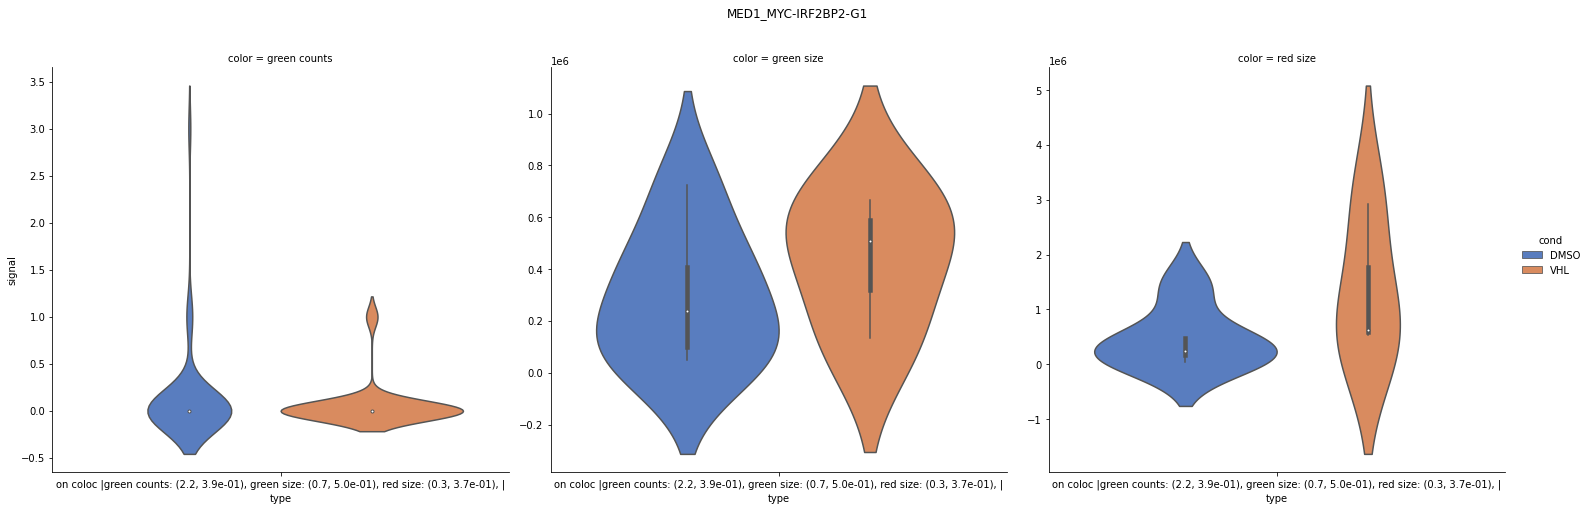

In [99]:
for k, val in data.items():
    g = sns.catplot(kind="violin", x="type", y="signal", hue="cond", col="color", data=val, palette="muted", sharey=False, height=7)
    g.fig.subplots_adjust(top=0.86)
    g.fig.suptitle(k)
    plt.show()
    g.savefig(folder+k+"_violin_oncobinding.pdf")

### on all

In [100]:
# compute difference in number/surface/max/min/mean(val) of green /red across cells and cobindings
data = {}
typ = [("sum_green_sum", "green sum"), ('sum_red_sum', "red sum"), ('mean_red_mean', "red mean"), ('mean_green_mean', "green mean"), ("area_sum", "size")]
for k in set(mdots.exp):
    print(k)
    print('______________________________\n')
    at = pd.DataFrame()
    
    for t in ['DMSO', 'VHL']:
        print(t)
        d = mdots[(mdots.exp==k)&(mdots.treat==t)]
        
        # counts per cell
        a = pd.DataFrame()
        b = pd.DataFrame()
        print("\ncount greens per cell:")
        e = [len(d[(d["group"]==cell)&(d['class']=="green")]) for cell in set(d.group)]
        print(min(e))
        print(np.mean(e), np.sqrt(np.var(e)))
        
        b["color"] = ['on green']*len(e)
        b['signal'] = e
        a = a.append(b)
        
        b = pd.DataFrame()
        e = [len(d[(d["group"]==cell)&(d['class']=="red")]) for cell in set(d.group)]
        b["color"] = ['on red']*len(e)
        b['signal'] = e
        a = a.append(b)
        
        b = pd.DataFrame()
        e = [len(d[(d["group"]==cell)&(d['class']=="cobinding")]) for cell in set(d.group)]
        b["color"] = ['on coloc']*len(e)
        b['signal'] = e
        a = a.append(b)
        
        a['type'] = "counts"
        a['cond'] = t
        at = at.append(a)
        
        # TOTAL signal
        
        b = pd.DataFrame()
        print("\ntotal signal greens per cell:")
        e = [sum(d[(d["group"]==cell)&(d['class']=="green")]['sum_green_sum']) for cell in set(d.group)]
        print(min(e))
        print(np.mean(e), np.sqrt(np.var(e)))
        
        b["color"] = ['on green']*len(e)
        b['signal'] = e
        a.append(b)
        
        b = pd.DataFrame()
        e = [sum(d[(d["group"]==cell)&(d['class']=="red")]['sum_red_sum']) for cell in set(d.group)]
        b["color"] = ['on red']*len(e)
        b['signal'] = e
        a = a.append(b)
        
        b = pd.DataFrame()
        e = [sum(d[(d["group"]==cell)&(d['class']=="cobinding")]['sum_green_sum']) for cell in set(d.group)]
        b["color"] = ['on coloc']*len(e)
        b['signal'] = e
        a.append(b)
        
        a['type'] = "total sum"
        a['cond'] = t
        at = at.append(a)
        
        for (col,name) in typ:
            print(name)
            a = pd.DataFrame()
            print('\nsignal in green:')
            e = d[d['class']=="green"][col].tolist()
            print(np.mean(e), np.sqrt(np.var(e)))
            b = pd.DataFrame()
            b['signal'] = e
            b['color'] = "on green"
            a = a.append(b)
            
            print('\nsignal in red:')
            e = d[d['class']=="red"][col].tolist()
            print(np.mean(e), np.sqrt(np.var(e)))
            
            b = pd.DataFrame()
            b['signal'] =  e
            b['color'] = "on red"
            a = a.append(b)

            print('\nsignal in cobinding:')
            e = d[d['class']=="cobinding"][col].tolist()
            print(np.mean(e), np.sqrt(np.var(e)))
            
            b = pd.DataFrame()
            b['signal'] = e
            b['color'] = "on coloc"           
            print('\n\n')
            a = a.append(b)
            a['type']=name
            a['cond'] = t
            at = at.append(a)
        print('____________\n')
    data[k] = at.reset_index(drop=True)
    
# adding chi2
for k,val in data.items():
    for i in set(val['type']):
        e = " |"
        for u in ['on green', "on red", "on coloc"]:#set(val['color']):
            a = val[(val['type'] == i) & (val['color'] == u) & (val['cond'] == "DMSO")]["signal"].tolist()
            b = val[(val['type'] == i) & (val['color'] == u) & (val['cond'] == "VHL")]["signal"].tolist()
            r = ttest_ind(a, b, equal_var=False)
            e+= u + ": ("f"{np.mean(a)/np.mean(b):.1f}, "f"{r[1]:.1e}), "
        val.loc[val[val['type'] == i].index, 'type'] = i + e +"|"
    data[k] = val

MED1_MYC-IRF2BP2-G1
______________________________

DMSO

count greens per cell:
36
213.68085106382978 105.85640743488497

total signal greens per cell:
14990909.0
206789754.93617022 138176342.1287653
green sum

signal in green:
967750.5209598725 1444554.0675776028

signal in red:
116687.20430107527 186359.03970853493

signal in cobinding:
1784678.8 913283.8103317939



red sum

signal in green:
187951.42138803148 362723.8419180372

signal in red:
2181333.7204301073 4416449.847561932

signal in cobinding:
4441287.2 3003745.872932622



red mean

signal in green:
599.2863535514193 781.8962819387091

signal in red:
4899.91381347807 1765.753135259606

signal in cobinding:
5282.035901700893 856.3442084008224



green mean

signal in green:
2634.59594827949 1067.9266919113459

signal in red:
335.4030262583175 400.1047023882223

signal in cobinding:
2719.4906362193324 1050.7499962042923



size

signal in green:
302147.90709947224 320782.2099836462

signal in red:
353573.7311827957 555705.07

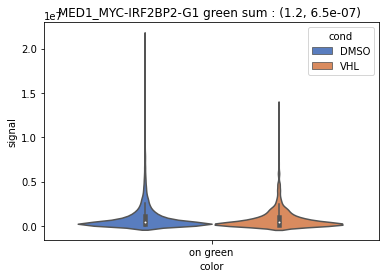

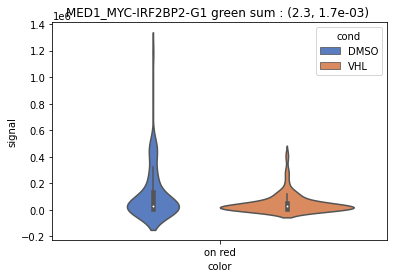

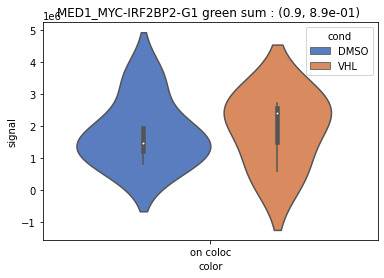

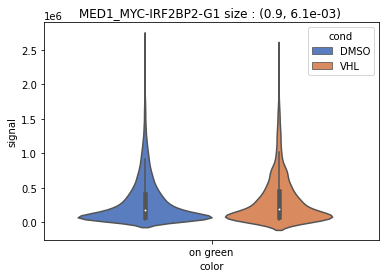

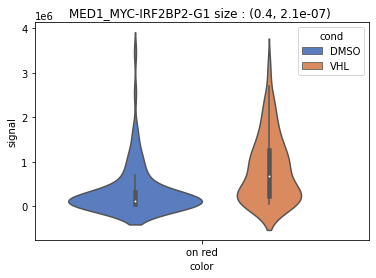

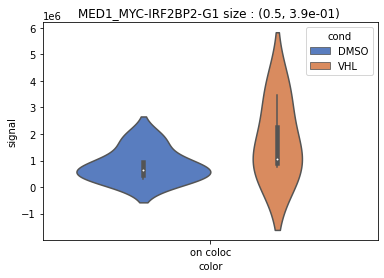

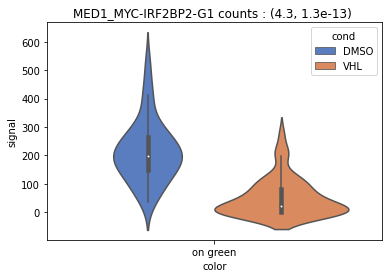

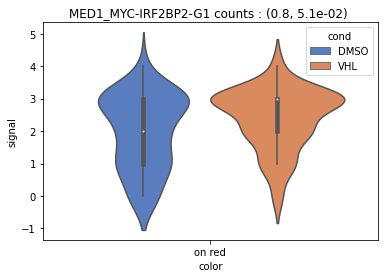

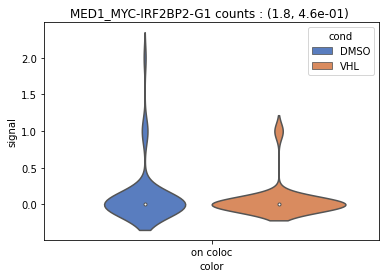

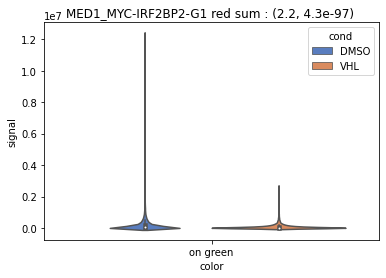

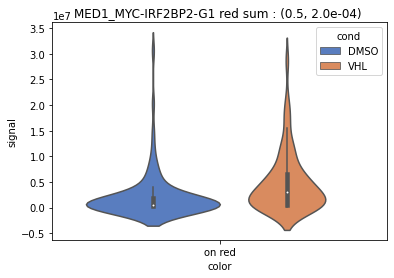

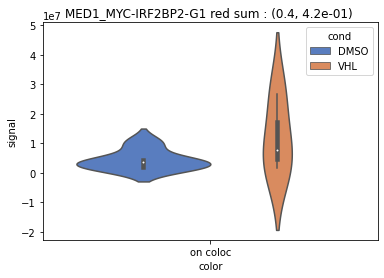

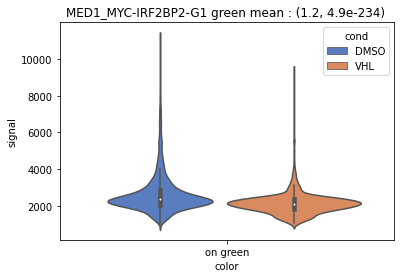

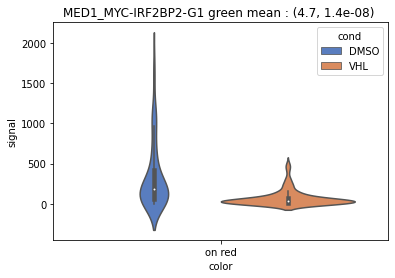

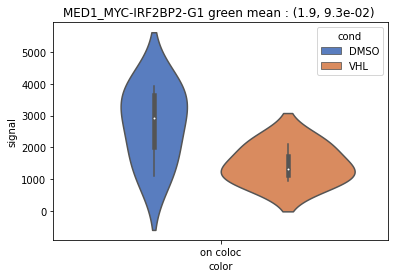

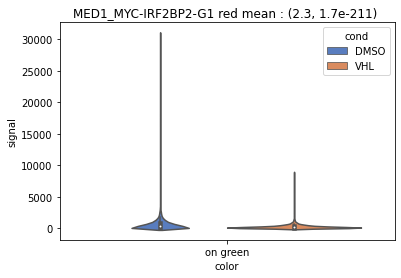

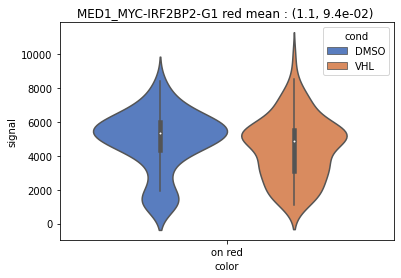

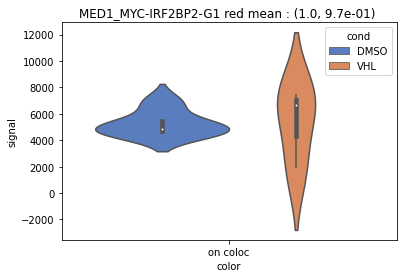

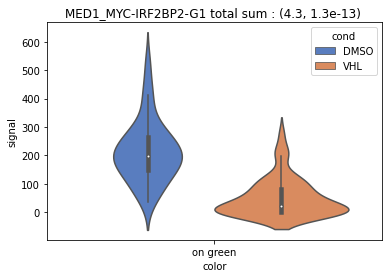

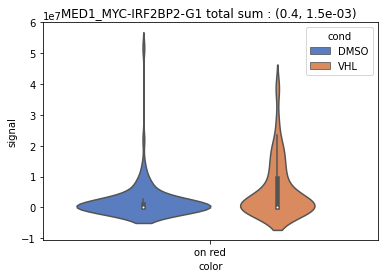

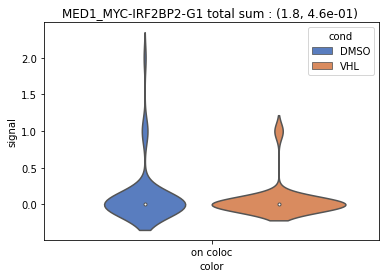

In [101]:
for k, v in data.items():
    for l in set(v['type']):
        for m in set(v['color']):
            try:
                ax = sns.violinplot(data = v[(v['type']==l)&(v['color']==m)], x="color", y="signal", hue="cond", palette="muted")
            except ValueError:
                print('no data to plot that one')
                continue
            plt.title(k+" "+l.split('|')[0]+""+l.split(m)[-1].split('),')[0]+") ")
            
            plt.show()
            
            ax.get_figure().savefig(folder+k+'_single_'+l.split(' |')[0]+"_"+m+".pdf")

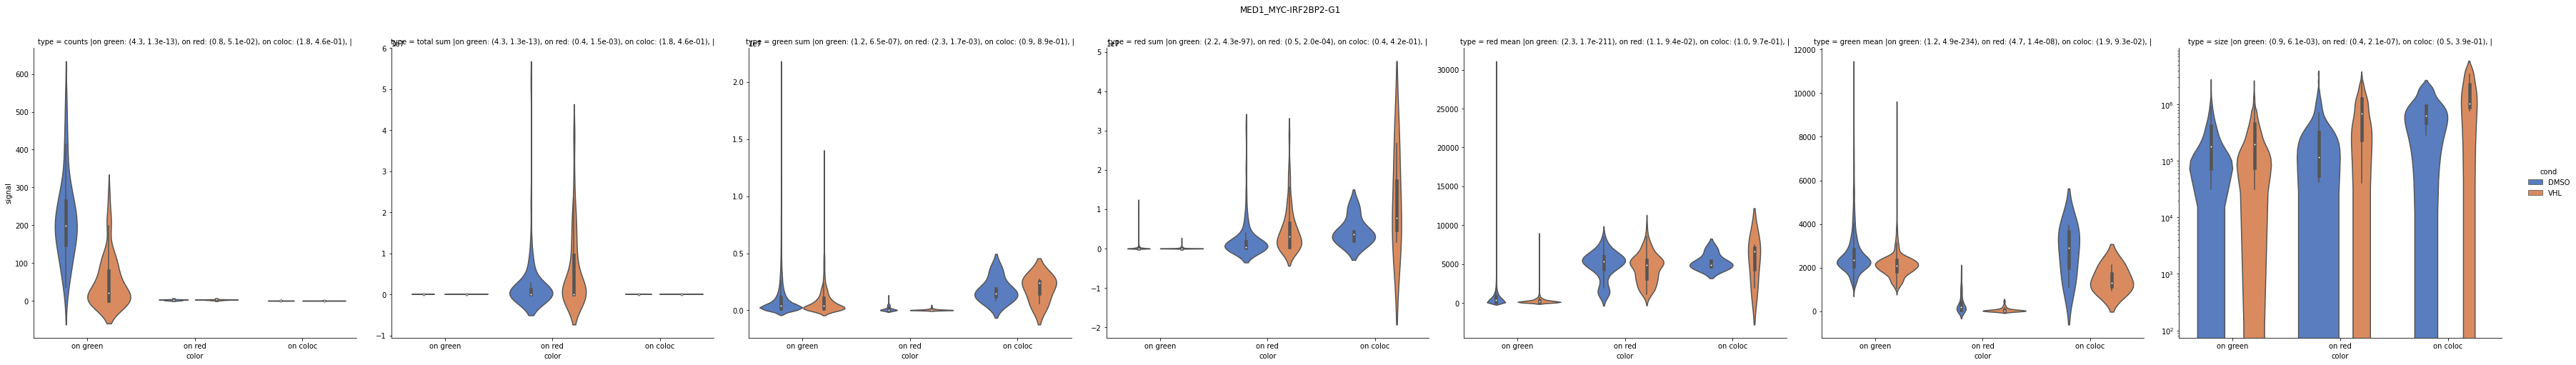

In [102]:
for k, val in data.items():
    g = sns.catplot(kind="violin", x="color", y="signal", hue="cond", col="type", data=val, palette="muted", sharey=False, height=7)
    g.fig.subplots_adjust(top=0.86)
    g.fig.suptitle(k)
    plt.yscale('log')
    plt.show()
    g.savefig(folder+k+"_violin_all.pdf")

/home/jeremie/.local/lib/python3.8/site-packages/venn/_backwards_compatibility.py:15: UserWarning: `get_labels()` is retained for backwards compatibility; use `generate_petal_labels()` or the higher level `venn()` instead
  warn((
/home/jeremie/.local/lib/python3.8/site-packages/venn/_backwards_compatibility.py:30: UserWarning: `venn2()` is retained for backwards compatibility; use `venn()` instead
  warn((


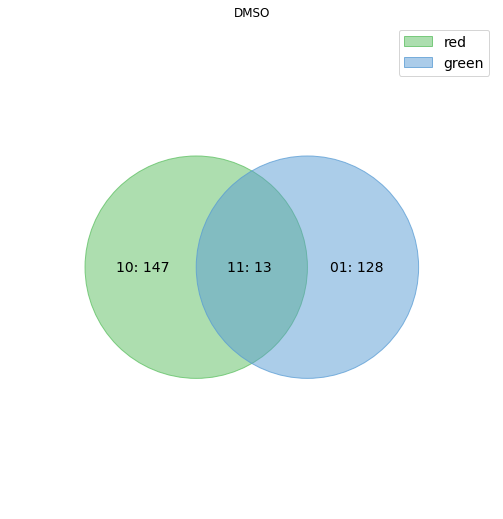

<Figure size 432x288 with 0 Axes>

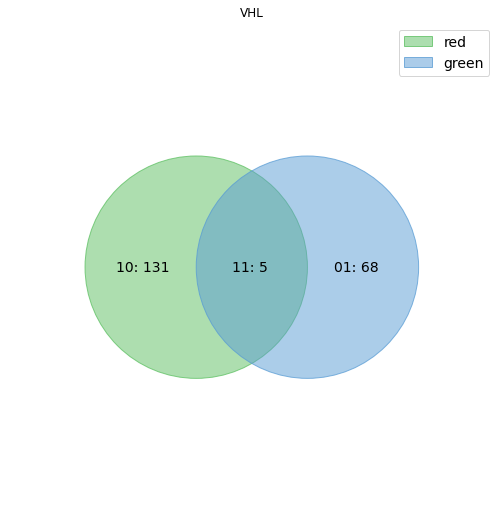

<Figure size 432x288 with 0 Axes>

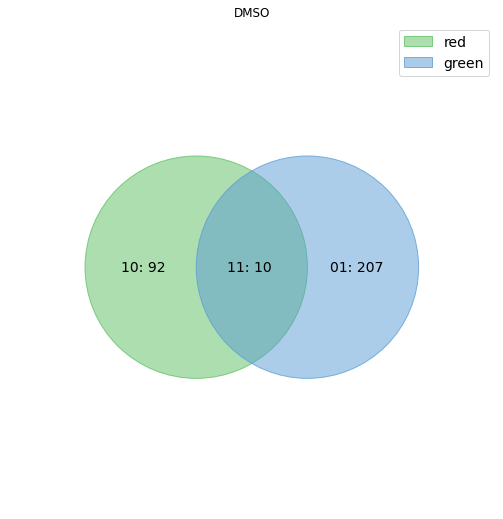

<Figure size 432x288 with 0 Axes>

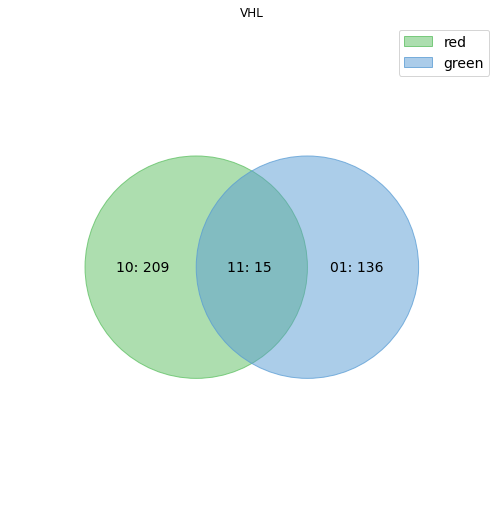

In [411]:
for val in ['MEF2D-MEF2C-G2','MEF2D-MEF2C-G1']:
    a = data[val]
    for v in ['DMSO','VHL']:
        f = int(a[(a.color=="on green")&(a.cond==v)&(a.type.str.contains('counts'))].signal.mean())
        e = int(a[(a.color=="on red")&(a.cond==v)&(a.type.str.contains('counts'))].signal.mean())
        i = int(a[(a.color=="on coloc")&(a.cond==v)&(a.type.str.contains('counts'))].signal.mean())
        c = f
        f = [u for u in range(f)]
        pe = [u for u in range(c, e+c)]
        c+=e
        e=pe
        e.extend([u for u in range(c, c+i)])
        f.extend([u for u in range(c, c+i)])
        plot.venn([set(e),set(f)], ["red", "green"], title=v)
        plt.savefig(folder+'MEF2D-MEF2C_venn'+v+'_mean_percell.pdf')

## likelyhood of coloc compared to expectation for each experiment &  between conditions

In [103]:
# compute dot likelyhood of coloc compared to expectation for each experiment &  between conditions
enrichment = {}

for k in set(mdots.exp):
    count = []
    fisher = []
    print('______________________________')
    print(k)
    for e in ['DMSO', 'VHL']:
        d = mdots[(mdots.exp==k)&(mdots.treat==e)]
        allredcount = len(d[d['class']!="green"])
        try:
            obs_cob = len(d[d['class']=="cobinding"])/allredcount
        except ZeroDivisionError:
            print('no red dot')
            continue
        obs_green = d[d['class']=="green"].area_sum.sum() * call_scale
        pred_cob = obs_green / mcells[(mcells.exp==k)&(mcells.treat==e)].area_sum.sum()
        #print(obs_cob, obs_green, pred_cob)
        count.append(obs_cob/pred_cob)
        print(e+": "+str(obs_cob/pred_cob))
        a = pred_cob*allredcount
        b = obs_cob*allredcount
        f = fisher_exact(np.array([[b, allredcount - b], [a, allredcount - a]], dtype=int))
        if f[0] is np.inf:
            f = (obs_cob/pred_cob, f[1])
        fisher.append(f)
    enrichment[k] = fisher
    print("change: "+str(count[1]/count[0]))

______________________________
MED1_MYC-IRF2BP2-G1
DMSO: 5.548649452561042
VHL: 10.780897542125869
change: 1.942976869290206


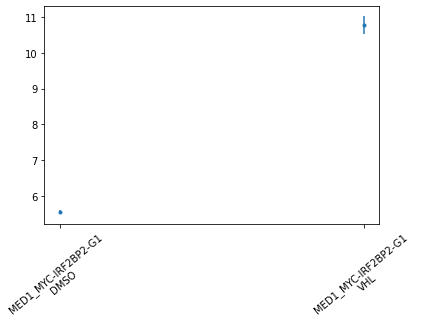

In [104]:
x=[]
y=[]
e=[]
for k, val in enrichment.items():
    x.append(k+'\nDMSO')
    y.append(val[0][0])
    e.append(val[0][1])
    x.append(k+'\nVHL')
    y.append(val[1][0])
    e.append(val[1][1])
plt.errorbar(x, y, e, linestyle='None', marker='.')
plt.xticks(rotation = 40) # Rotates X-Axis Ticks by 45-degrees
plt.savefig(folder+"_"+version+'_enrichments.pdf')

## plot of averaged binned signal by distance from focis

In [105]:
set(res['group'])

{'MED1_MYC-IRF2BP2-DMSO-G1--4--1-1',
 'MED1_MYC-IRF2BP2-DMSO-G1--4--1-2',
 'MED1_MYC-IRF2BP2-DMSO-G1--4--2-1',
 'MED1_MYC-IRF2BP2-DMSO-G1--4--2-2',
 'MED1_MYC-IRF2BP2-DMSO-G1--4--2-3',
 'MED1_MYC-IRF2BP2-DMSO-G1--4--3-1',
 'MED1_MYC-IRF2BP2-DMSO-G1--4--4-1',
 'MED1_MYC-IRF2BP2-DMSO-G1--4--4-2',
 'MED1_MYC-IRF2BP2-DMSO-G1--4--4-3',
 'MED1_MYC-IRF2BP2-DMSO-G1--4--4-4',
 'MED1_MYC-IRF2BP2-DMSO-G1--4--4-5',
 'MED1_MYC-IRF2BP2-DMSO-G1--4--5-1',
 'MED1_MYC-IRF2BP2-DMSO-G1--4--5-2',
 'MED1_MYC-IRF2BP2-DMSO-G1--4--5-3',
 'MED1_MYC-IRF2BP2-DMSO-G1--4--6-1',
 'MED1_MYC-IRF2BP2-DMSO-G1--4--6-2',
 'MED1_MYC-IRF2BP2-DMSO-G1--4--6-3',
 'MED1_MYC-IRF2BP2-DMSO-G1--4--6-4',
 'MED1_MYC-IRF2BP2-DMSO-G1--4--6-5',
 'MED1_MYC-IRF2BP2-DMSO-G1--4--8-1',
 'MED1_MYC-IRF2BP2-DMSO-G1--4--8-2',
 'MED1_MYC-IRF2BP2-DMSO-G1--4--8-3',
 'MED1_MYC-IRF2BP2-DMSO-G1--4--9-1',
 'MED1_MYC-IRF2BP2-DMSO-G1--4--9-2',
 'MED1_MYC-IRF2BP2-DMSO-G1--54--1-1',
 'MED1_MYC-IRF2BP2-DMSO-G1--58_SIM--1-1',
 'MED1_MYC-IRF2BP2-DMSO-G1--58_S

In [106]:
# make a plot of averaged binned signal strength by distance from locis
twodists, dists = fish.computeDistsFromClass(agreen, mred, conds=['DMSO', 'VHL'], groupcol="group", sclass='green', signal="mean_green", area="area")

MED1_MYC-IRF2BP2-G1 DMSO
MED1_MYC-IRF2BP2-G1 VHL


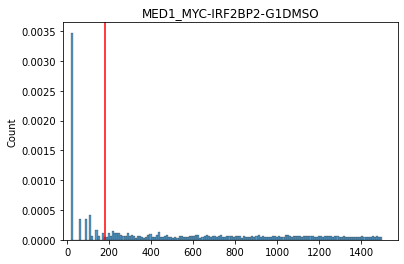

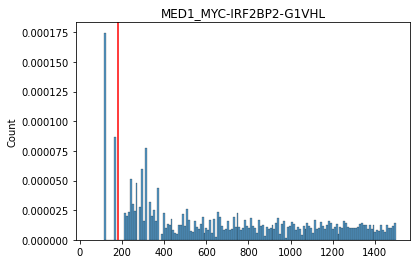

In [107]:
size=1500
bins = 150
defa = size/bins
for k, v in dists.items():
    plt.title(k)
    scale = ((4.19*(defa+v[0][v[0]<size]))**3)-((4.19*(v[0][v[0]<size]))**3)
    ax = sns.histplot(x=v[0][v[0]<size], weights=v[1][v[0]<size]/scale, bins=bins, fill=True)
    plt.axvline(x=180, color="red")
    ax.set(xlim=(-20,None))
    plt.show()
    ax.get_figure().savefig(folder+k+'_1D_distances_from_red.pdf')

In [587]:
norm = {'MED1-MYC_MEF2D-G1':(2000,5000), 
        'MED1-MYC_MEF2D-G2':(2000,5000),
        'MEF2C-MYC_MEF2D-G2':(2000,5000),
        'MEF2C-MYC_MEF2D-G1':(2000,5000),
        'MEF2D-MYC_MEF2D-G1':(2000,5000)
       }

In [70]:
twodists.keys()

dict_keys(['MED1_MYC-IRF2BP2-G1DMSO', 'MED1_MYC-IRF2BP2-G1VHL'])

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:1676: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


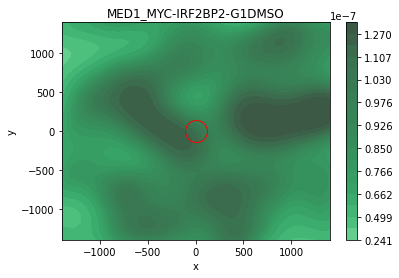

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:1676: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


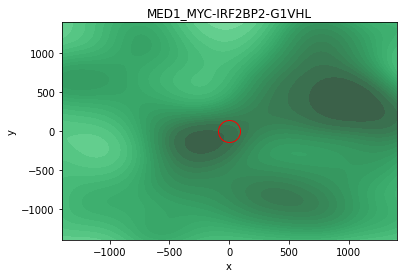

In [110]:
fish.drawDots(twodists, scenter=22, size=1400, zsize=800, folder=folder+'greenall_', signal="mean_green",area="area", sizes=(100,250), alpha=0.1, levels=20, vmin=0.2e-7, vmax=1.3e-7,)#second=lambda x: x.index.isin(adots[adots.index.isin(x.index.tolist()) & adots.m_id.isin(mdots[mdots['class'] == "cobinding"].index)].index))

In [765]:
1467.3437625617464/2135.261462781994

0.6871962933522766

In [ ]:
ls 

In [731]:
norm = {'MED1-MYC_MEF2D-G1':(1000,5000), 
        'MED1-MYC_MEF2D-G2':(2000,5000),
        'MEF2C-MYC_MEF2D-G2':(2000,5000),
        'MEF2C-MYC_MEF2D-G1':(2000,5000),
        'MEF2D-MYC_MEF2D-G1':(2000,5000)
       }

<Figure size 432x288 with 0 Axes>

In [483]:
for k in ['MED1-MYC_MEF2D-G1','MED1-MYC_MEF2D-G2','MEF2C-MYC_MEF2D-G2','MEF2C-MYC_MEF2D-G1','MEF2D-MYC_MEF2D-G1']:
    fish.drawDots({i: twodists[i] for i in twodists.keys() if k in i}, scenter=85, size=400, zsize=600, folder=folder+'coloconly_', signal="mean_green", area="area", sizes=(400,850), palette=sns.light_palette("orange", as_cmap=True), alpha=0.4, norm=norm[k])

KeyError: 'mean_green'

In [474]:
# make a plot of averaged binned signal strength by distance from locis
twodists, _ = fish.computeDistsFromClass(ared[~ared.group.str.contains("MEF2D-MEF2C")], mred[~mred.group.str.contains("MEF2D-MEF2C")], conds=['DMSO', 'VHL'], groupcol="group", sclass='red', signal="mean_red", area="area")

MEF2D-MYC_MEF2D-G1 DMSO
MEF2D-MYC_MEF2D-G1 VHL
MEF2C-MYC_MEF2D-G2 DMSO
MEF2C-MYC_MEF2D-G2 VHL
MED1-MYC_MEF2D-G1 DMSO
MED1-MYC_MEF2D-G1 VHL
MEF2C-MYC_MEF2D-G1 DMSO
MEF2C-MYC_MEF2D-G1 VHL


In [479]:
norm = {'MED1-MYC_MEF2D-G1':(2000,15000), 
        'MED1-MYC_MEF2D-G2':(4000,20000),
        'MEF2C-MYC_MEF2D-G2':(4000,20000),
        'MEF2C-MYC_MEF2D-G1':(4000,20000),
        'MEF2D-MYC_MEF2D-G1':(2000,8000)
       }

<Figure size 432x288 with 0 Axes>

In [637]:
for k in ['MED1-MYC_MEF2D-G1','MED1-MYC_MEF2D-G2','MEF2C-MYC_MEF2D-G2','MEF2C-MYC_MEF2D-G1','MEF2D-MYC_MEF2D-G1']:
    fish.drawDots({i: twodists[i] for i in twodists.keys() if k in i}, scenter=75, size=400, zsize=600, folder=folder+'redonly', signal="mean_red", area="area", sizes=(400,850), palette=sns.light_palette("red", as_cmap=True), alpha=0.05, norm=norm[k])

KeyError: "['mean_red'] not in index"

In [ ]:
size=400
lim = 100
bins=60
s = 25
maxv=10
for k in ['MED1-MYC_MEF2D-G1','MED1-MYC_MEF2D-G2','MEF2C-MYC_MEF2D-G2','MEF2C-MYC_MEF2D-G1','MEF2D-MYC_MEF2D-G1']:
    for u, v in {i: twodists[i] for i in twodists.keys() if k in i}.items():
        p = sns.jointplot(data=v[(abs(v.x)<size) & (abs(v.y)<size)], x="x", y="y",  kind="hex", color="red", joint_kws={'weights':"mean_red"}, xlim=(-lim,lim), ylim=(-lim,lim), gridsize=bins, vmax=maxv)
        p.plot_marginals(sns.distplot, rug=True, hist_kws={"range":(0,maxv)})
        p.plot_joint(sns.kdeplot, color="black", xlim=(-lim,lim), ylim=(-lim,lim), weights="mean_red", linewidth=1, alpha=.5)

        # gridsize=50, kind="hex", marginal_kws=dict(bins=50))
        # hue="sum_green_sum")
        x_values = [0]#, 2, 3, 4]
        y_values = [0]#, 0, 0, 0]
        #p.ax_joint.plot(x_values, y_values, 'o', ms=s, markerfacecolor="None",
        #    markeredgecolor='white', markeredgewidth=1)
        p.fig.suptitle(u)
        plt.show()
    
        p.savefig(folder+u+'_2D_distances_from_red.pdf')
    break

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:1182: UserWarning: The following kwargs were not used by contour: 'xlim', 'ylim', 'linewidth'
  cset = contour_func(


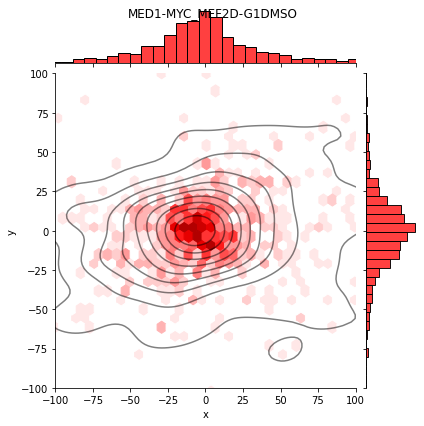

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:1182: UserWarning: The following kwargs were not used by contour: 'xlim', 'ylim', 'linewidth'
  cset = contour_func(


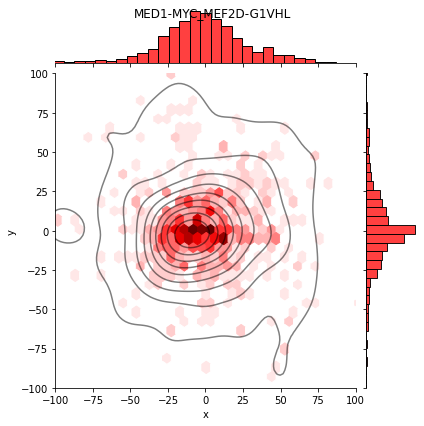

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:1182: UserWarning: The following kwargs were not used by contour: 'xlim', 'ylim', 'linewidth'
  cset = contour_func(


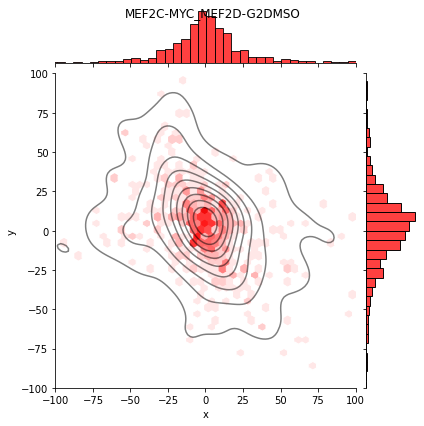

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:1182: UserWarning: The following kwargs were not used by contour: 'xlim', 'ylim', 'linewidth'
  cset = contour_func(


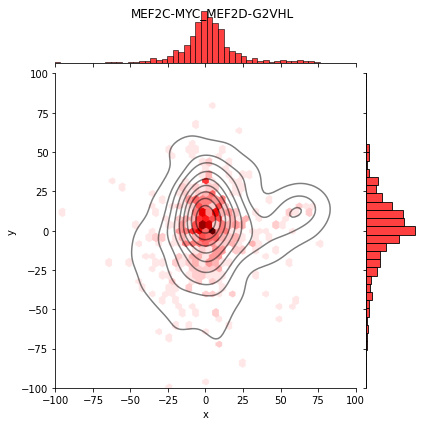

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:1182: UserWarning: The following kwargs were not used by contour: 'xlim', 'ylim', 'linewidth'
  cset = contour_func(


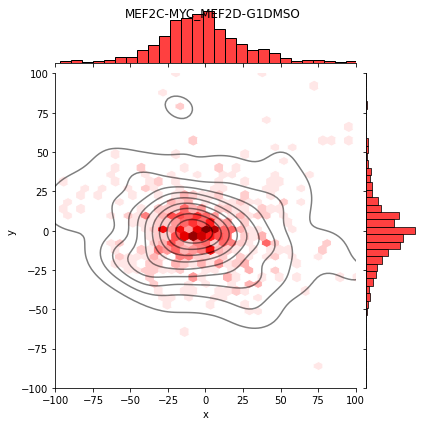

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:1182: UserWarning: The following kwargs were not used by contour: 'xlim', 'ylim', 'linewidth'
  cset = contour_func(


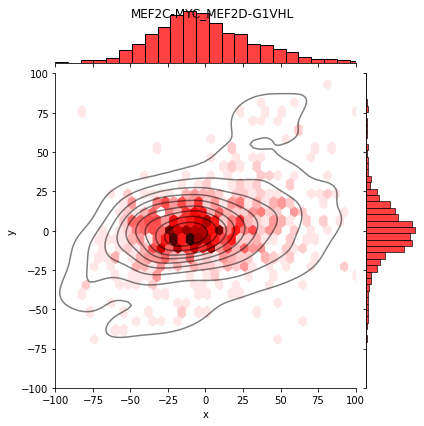

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:1182: UserWarning: The following kwargs were not used by contour: 'xlim', 'ylim', 'linewidth'
  cset = contour_func(


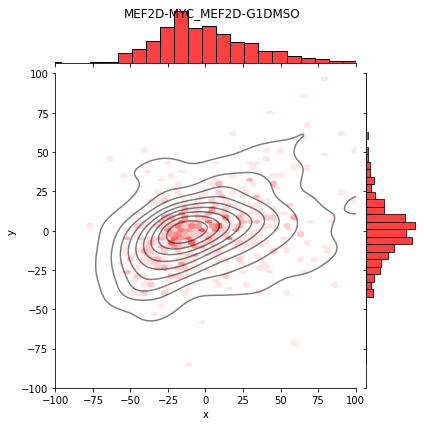

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:1182: UserWarning: The following kwargs were not used by contour: 'xlim', 'ylim', 'linewidth'
  cset = contour_func(


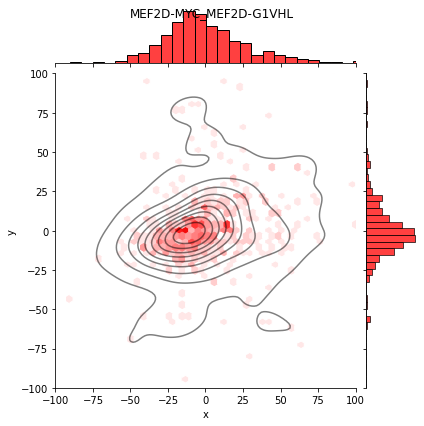

In [584]:
size=200
lim = 100
bins=60
s = 25
for k in ['MED1-MYC_MEF2D-G1','MED1-MYC_MEF2D-G2','MEF2C-MYC_MEF2D-G2','MEF2C-MYC_MEF2D-G1','MEF2D-MYC_MEF2D-G1']:
    for u, v in {i: twodists[i] for i in twodists.keys() if k in i}.items():
        p = sns.jointplot(data=v[(abs(v.x)<size) & (abs(v.y)<size)], x="x", y="y",  kind="hex", color="red",  xlim=(-lim,lim), ylim=(-lim,lim), gridsize=bins, vmin=0, vmax=20)
        sns.kdeplot(data=v[(abs(v.x)<size) & (abs(v.y)<size)][["x",'y','mean_red']].astype(float), x="x", y="y", color="black", xlim=(-lim,lim), ylim=(-lim,lim), weights="mean_red", linewidth=1, alpha=.5)

        # gridsize=50, kind="hex", marginal_kws=dict(bins=50))
        # hue="sum_green_sum")
        x_values = [0]#, 2, 3, 4]
        y_values = [0]#, 0, 0, 0]
        #p.ax_joint.plot(x_values, y_values, 'o', ms=s, markerfacecolor="None",
        #    markeredgecolor='white', markeredgewidth=1)
        p.fig.suptitle(u)
        plt.show()
    
        p.savefig(folder+u+'_2D_distances_from_red.pdf')

In [585]:
# apply plot to old data from juliana    

In [ ]:
# make a nice fake plot
sns.plot()

In [194]:
mv $folder '../results/FishSuperResColoc/plots_v3_withfilter/'

## saving

In [200]:
! cd .. && git add . && git commit -m "adding whiskers" && git push

[master a1525e5] adding whiskers
 292 files changed, 324615 insertions(+), 10805 deletions(-)
 rewrite notebooks/Fish_SuperRes.ipynb (66%)
 create mode 100644 results/FishSuperResColoc/plots_v3_withfilter/MED1-MYC_MEF2DDMSO_1D_distances_from_red.pdf
 create mode 100644 results/FishSuperResColoc/plots_v3_withfilter/MED1-MYC_MEF2DDMSO_2D_distances_from_red.pdf
 create mode 100644 results/FishSuperResColoc/plots_v3_withfilter/MED1-MYC_MEF2DDMSO_scatter_representation_size_to_center.pdf
 create mode 100644 results/FishSuperResColoc/plots_v3_withfilter/MED1-MYC_MEF2DVHL_1D_distances_from_red.pdf
 create mode 100644 results/FishSuperResColoc/plots_v3_withfilter/MED1-MYC_MEF2DVHL_2D_distances_from_red.pdf
 create mode 100644 results/FishSuperResColoc/plots_v3_withfilter/MED1-MYC_MEF2DVHL_scatter_representation_size_to_center.pdf
 create mode 100644 results/FishSuperResColoc/plots_v3_withfilter/MED1-MYC_MEF2D_single_counts _on coloc.pdf
 create mode 100644 results/FishSuperResColoc/plots_v3_wi

Enumerating objects: 233, done.
Counting objects: 100% (233/233), done.
Delta compression using up to 8 threads
Compressing objects: 100% (227/227), done.
Writing objects: 100% (227/227), 39.30 MiB | 4.56 MiB/s, done.
Total 227 (delta 196), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (196/196), completed with 4 local objects.
remote: warning: GH001: Large files detected. You may want to try Git Large File Storage - https://git-lfs.github.com.
remote: warning: See http://git.io/iEPt8g for more information.
remote: warning: File results/FishSuperResColoc/v3_annotated_green.csv is 85.88 MB; this is larger than GitHub's recommended maximum file size of 50.00 MB
remote: warning: File results/FishSuperResColoc/v3_all.csv is 99.44 MB; this is larger than GitHub's recommended maximum file size of 50.00 MB
remote: 
remote: GitHub found 1 vulnerability on jkobject/AMLproject's default branch (1 moderate). To find out more, visit:
remote:      https://github.com/jkobject/AMLp